In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import scipy.optimize as opt
import sys

In [2]:
dir_name = '../../../rslaser/package_data/'
file_name = 'IntensityImage_OffPeakTiming.txt'

In [3]:
img_orig = np.genfromtxt(dir_name+file_name, skip_header=1)

i_max = img_orig.shape[1] - 1
j_max = img_orig.shape[0] - 1

x = np.linspace(0, i_max+1, img_orig.shape[1])
y = np.linspace(0, j_max+1, img_orig.shape[0])
x, y = np.meshgrid(x, y)

n0_min=np.min(img_orig)
n0_max=np.max(img_orig)
n0_tot = np.sum(img_orig)
print('n0_max = ', n0_max)
print('n0_tot = ', n0_tot)

sigma0 = math.sqrt(n0_tot / n0_max / math.pi)
print('sigma_0 = ', sigma0)

# find indices of the maximum value; assume this is the center
y_center, x_center = np.unravel_index(np.argmax(img_orig),img_orig.shape)
print('x_center = ', x_center)
print('y_center = ', y_center)

n0_max =  76218.0
n0_tot =  25395610.0
sigma_0 =  10.298538903582863
x_center =  20
y_center =  15


In [4]:
def gaussian(_x,_y,_amp,_sigma,_xc,_yc):
    r_over_sigma_sq = ((_x-_xc)/_sigma)**2 + ((_y-_yc)/_sigma)**2
    return _amp * np.exp(-r_over_sigma_sq)

In [5]:
def merit_fcn(sigma, args):
    img_fit = gaussian(args[0],args[1],n0_max,sigma,x_center,y_center).reshape(img_orig.shape)
    return abs(n0_tot - np.sum(img_fit))

In [6]:
x0 = [math.sqrt(n0_tot/n0_max/math.pi)]
# popt, pcov = opt.curve_fit(gaussian, (x, y), img_orig.flatten(), p0=initial_guess, maxfev=10000)
result = opt.minimize(merit_fcn, x0, args=[x, y], method='Nelder-Mead', options={'xatol': 0.0001, 'fatol': 0.0001, 'disp': True})
print(' ')
print('guess = ', math.sqrt(n0_tot/n0_max/math.pi))
print('result = ', result.x[0])

Optimization terminated successfully.
         Current function value: 0.000226
         Iterations: 33
         Function evaluations: 66
 
guess =  10.298538903582863
result =  10.809626359254757


In [7]:
_max = n0_max
_sig = result.x[0]
print('_max = {0:4.1f}'.format(_max))
print('_sig = {0:4.1f}'.format(_sig))
print(' ')

img_fit = gaussian(x, y, _max, _sig, x_center, y_center).reshape(img_orig.shape)
nfit_max = np.max(img_fit)
rel_max_dif = 100.*(1.-nfit_max/n0_max)
print('relative difference of peak value = {0:4.1f}%'.format(rel_max_dif))

nfit_tot = np.sum(img_fit)
rel_tot_dif = 100.*(1.-nfit_tot/n0_tot)
print('nfit_tot = ', nfit_tot)
print('relative difference of total counts = {0:4.1f}%'.format(rel_tot_dif))

_max = 76218.0
_sig = 10.8
 
relative difference of peak value =  0.4%
nfit_tot =  25395610.000226054
relative difference of total counts = -0.0%


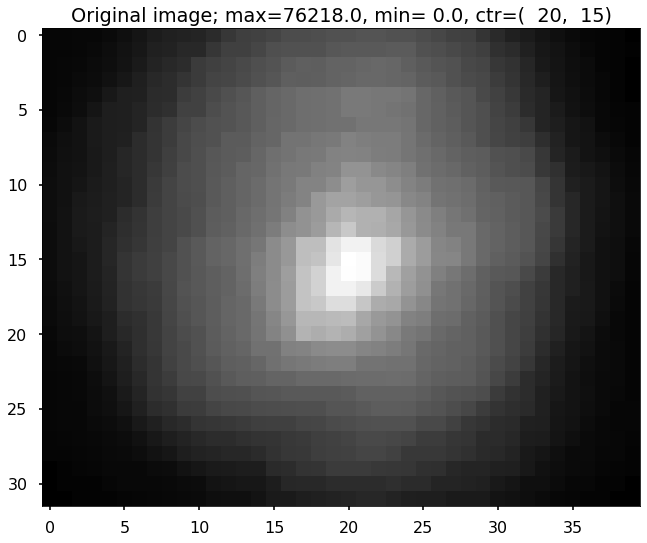

In [8]:
# plot twoD_Gaussian data generated above
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(img_orig, cmap='gray', vmin=0., vmax=nfit_max)
    ax.set_title('Original image; max={0:4.1f}'.format(n0_max)+', min={0:4.1f}'.format(n0_min)+', ctr=({0:4.0f},'.format(x_center)+'{0:4.0f})'.format(y_center))

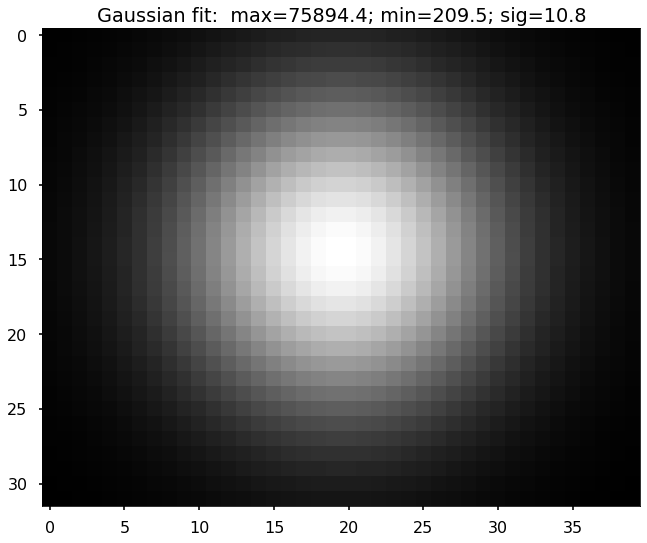

In [9]:
# plot twoD_Gaussian data generated above
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(img_fit, cmap='gray', vmin=0., vmax=nfit_max)
    ax.set_title('Gaussian fit:  max={0:4.1f}; '.format(np.max(img_fit))+'min={0:4.1f}; '.format(np.min(img_fit))+'sig={0:4.1f}'.format(_sig))

min_diff =  -26975.730971386976
max_diff =  15150.340669811243
ndif_tot =  -0.00022605026606470346
relative deviation (above) =  19.87764133119636 %
relative deviation (below) =  35.3928612288265 %


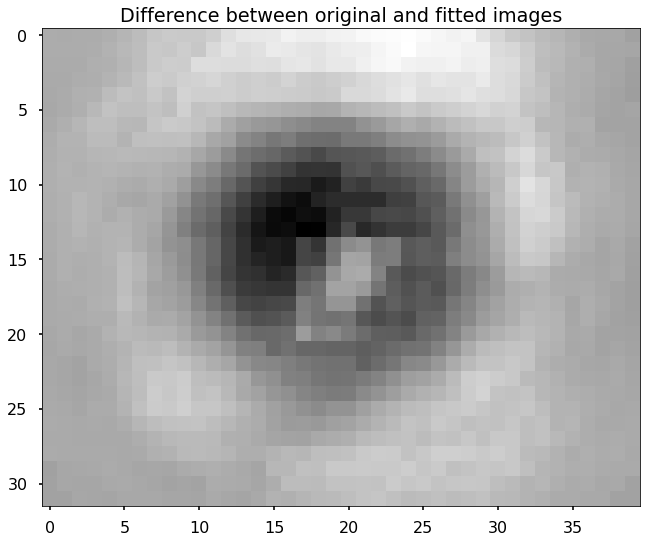

In [10]:
img_diff = img_orig - img_fit

print('min_diff = ', np.min(img_diff))
print('max_diff = ', np.max(img_diff))

ndif_tot = np.sum(img_diff)
print('ndif_tot = ', ndif_tot)
    
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(img_diff, cmap='gray', vmin=np.min(img_diff), vmax=np.max(img_diff))
    ax.set_title("Difference between original and fitted images")

print('relative deviation (above) = ', 100.*(np.max(img_diff)/n0_max), '%')
print('relative deviation (below) = ', 100.*(abs(np.min(img_diff))/n0_max), '%')

In [11]:
print(' ')
print('*************************')
# print('img_orig = ')
# print(img_orig)
min_orig = np.min(img_orig)
max_orig = np.max(img_orig)
print('min original = ', min_orig)
print('max original = ', max_orig)

print(' ')
print('*************************')
# print('img_fit = ')
# print(img_fit)
min_fit = np.min(img_fit)
max_fit = np.max(img_fit)
print('min fitted = ', min_fit)
print('max fitted = ', max_fit)

print(' ')
print('*************************')
# print('img_diff = ')
# print(img_diff)
min_diff = np.min(img_diff)
max_diff = np.max(img_diff)
print('min diff = ', min_diff)
print('max diff = ', max_diff)

 
*************************
min original =  0.0
max original =  76218.0
 
*************************
min fitted =  209.51695827751328
max fitted =  75894.42838392184
 
*************************
min diff =  -26975.730971386976
max diff =  15150.340669811243
